# input pipeline

In [1]:
import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
tf.__version__ # make sure it is >=2.6.2
# !pip install --upgrade tensorflow

'2.6.2'

In [3]:
target_shape = (200,200)
batch_size = 64

def preprocess_image(filename, coords):
    # source: https://keras.io/examples/vision/siamese_network/
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.convert_to_tensor(image)
    x = tf.math.maximum(tf.cast(coords[0], tf.int32),0)
    y = tf.math.maximum(tf.cast(coords[1], tf.int32),0)
    w = tf.math.minimum(tf.cast(coords[2], tf.int32),tf.subtract(tf.shape(image)[1],x))
    h = tf.math.minimum(tf.cast(coords[3], tf.int32),tf.subtract(tf.shape(image)[0],y))
    image = tf.slice(image, [y,x,0], [h,w,-1] )
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    image = tf.reshape(image, target_shape + (3,))
    return image


def decode_csv(line, video):
    record_defaults = [-1.]*9
    parsed_line = tf.io.decode_csv(line, record_defaults)
    features = tf.stack(tf.concat((parsed_line,[video]),0))  # Stack features so that you can later vectorize forward prop., etc.
    return features

def get_filename(video, frame):
    # preprocess tensors
    frame = tf.strings.as_string(tf.cast(frame, tf.int32))
    video = tf.strings.as_string(tf.cast(video, tf.int32))
    # get the leading zeros
    num_zeros_frame = tf.subtract(6,tf.strings.length(frame))
    leading_zeros_frame = tf.repeat("0",num_zeros_frame,0)
    leading_zeros_frame = tf.strings.reduce_join(leading_zeros_frame)
    num_zeros_video = tf.subtract(2,tf.strings.length(video))
    leading_zeros_video = tf.repeat("0",num_zeros_video,0)
    leading_zeros_video = tf.strings.reduce_join(leading_zeros_video)    
    # get the filename
    filename = tf.add("data/train/MOT16-", leading_zeros_video)
    filename = tf.add(filename, video)
    filename = tf.add(filename,"/img1/")
    filename = tf.add(filename, leading_zeros_frame)
    filename = tf.add(filename, frame)
    filename = tf.add(filename, ".jpg")
#     for i in filename:
#         print(i)
    return filename

def get_object(gt_line):
    video = gt_line[-1]
    frame = gt_line[0]
#     id_ = gt_line[1]
    coords = gt_line[2:6]  
    filename = get_filename(video, frame)
    image = preprocess_image(filename, coords)
#     return image,tf.cast(video,tf.int32),tf.cast(frame,tf.int32),tf.cast(id_,tf.int32)
    return image#,video,frame,id_

def read_gt(filename):
    video = tf.strings.split(filename,os.sep)[2]
    video = tf.strings.substr(video, 6, 2)
    video = tf.strings.to_number(video, tf.float32)
    gt = tf.data.TextLineDataset(filename).map(lambda x: decode_csv(x,video))
    return gt


# dataset = tf.data.Dataset.from_tensor_slices(["data/train/MOT16-02/gt/gt.txt","data/train/MOT16-04/gt/gt.txt"])
train_filepaths = glob.glob("data/train/*/gt/gt.txt")[:-1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_filepaths)
train_dataset = train_dataset.flat_map(read_gt)
train_anchor = train_dataset.map(get_object)
train_positive = train_dataset.shuffle(8).map(get_object) # or skip(5)?
train_negative = train_dataset.shuffle(2^16).map(get_object)

train_dataset = tf.data.Dataset.zip((train_anchor, train_positive, train_negative))
train_dataset = train_dataset.shuffle(buffer_size=2^16)
train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)


# dataset = tf.data.Dataset.from_tensor_slices(["data/train/MOT16-02/gt/gt.txt","data/train/MOT16-04/gt/gt.txt"])
val_filepaths = glob.glob("data/train/*/gt/gt.txt")[-1:]
val_dataset = tf.data.Dataset.from_tensor_slices(val_filepaths)
val_dataset = val_dataset.flat_map(read_gt)
val_anchor = val_dataset.map(get_object)
val_positive = val_dataset.shuffle(8).map(get_object) # or skip(5)?
val_negative = val_dataset.shuffle(2^16).map(get_object)

val_dataset = tf.data.Dataset.zip((val_anchor, val_positive, val_negative))
val_dataset = val_dataset.shuffle(buffer_size=2^16)
val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

# siamese network (same as websitekeras)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)


In [5]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [6]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [7]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


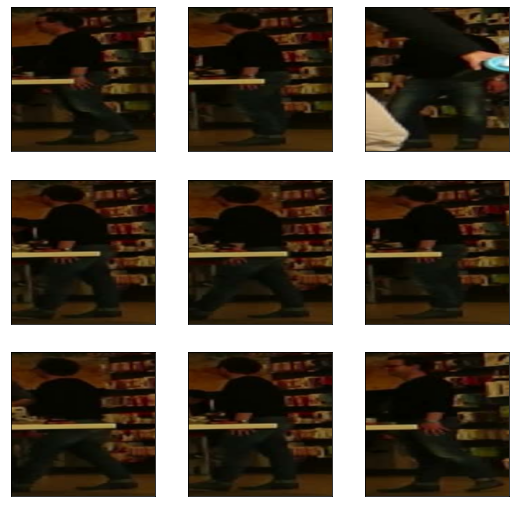

In [8]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

sample = next(iter(train_dataset))
visualize(*sample)

In [9]:
# before training
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.99765164
Negative similarity 0.9972452


In [ ]:
# about 6 hours per epoch with batch size of 64 I have about 1875 steps 
# (~20000 triplet per video, 6 video in training set) to take 
# TODO: parallelize?
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, batch_size = batch_size)

Epoch 1/10
    269/Unknown - 3285s 12s/step - loss: 0.4353

Positive similarity: 0.9995215
Negative similarity 0.9985951


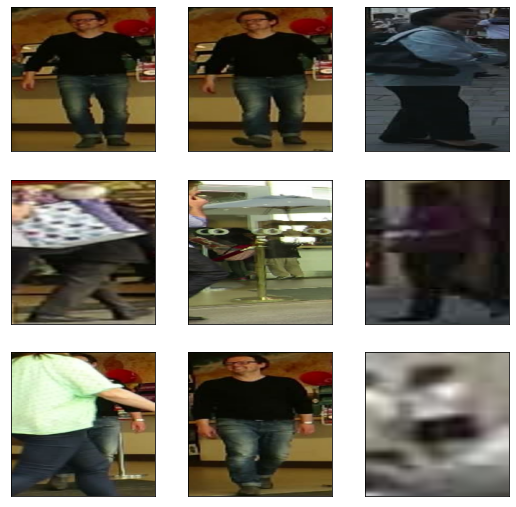

In [13]:
# after training
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


# new model

In [218]:
# the code in this cell is largely based on the code found here: https://keras.io/examples/vision/siamese_network/

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [219]:
# embedding using resnet and setting the last layers to be trainable
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True # instead of True
    layer.trainable = trainable


In [220]:
# distance layer
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, other):
        distance = tf.reduce_sum(tf.square(anchor - other), -1)
        return distance


In [221]:
# define the custome loss
def my_loss_fn(ap_distance, an_distance):
    ap_distance, an_distance = self.siamese_network(data)
    loss = ap_distance - an_distance
    loss = tf.maximum(loss + self.margin, 0.0)
    return loss 

In [231]:
# build up the model

# inputs
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# distances
ap_distance = DistanceLayer(name="ap_distance")(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input))
)

an_distance =  DistanceLayer(name="an_distance")(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(negative_input))
)

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=ap_distance)

# create loss as a tensor
# loss = tf.maximum(tf.subtract(ap_distance, an_distance) + 0.5, 0.0)

# add the loss to the model
# model.add_loss(loss)

model.compile(loss = "mse",optimizer=optimizers.Adam(0.0001))
model.fit(iter(train_dataset), epochs=10, validation_data=val_dataset)

ValueError: For performance reasons Keras `fit`, `evaluate` and`predict` accept tf.data `Datasets` as input but not iterators that have been manually generated from Datasets by users. Please directly pass in the original `Dataset` object instead of passing in `iter(dataset)`.

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    


    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
# siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# old model

In [180]:
# the code in this cell is largely based on the code found here: https://keras.io/examples/vision/siamese_network/

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [181]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True # instead of True
    layer.trainable = trainable


In [212]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1, name="ap_distance")
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1, name="an_distance")
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [213]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [214]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


# visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [215]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
# siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

In [216]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, sample_weight = {"ap_distance" : [1.0], "an_distance" : [1.0]})

ValueError: `sample_weight` argument is not supported when using dataset as input.

In [211]:
train_dataset

<PrefetchDataset shapes: ((200, 200, 3), (200, 200, 3), (200, 200, 3)), types: (tf.float32, tf.float32, tf.float32)>

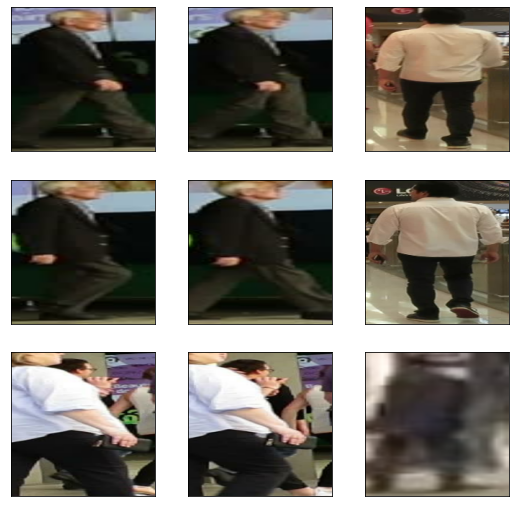

In [197]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())
